In [396]:
import sys # for automation and parallelization: set manual to false when run by a launcher
import json
default = {'scenario': 'futur_express', 'training_folder':'../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))


In [397]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)
from syspy.spatial import spatial, utils
io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

num cores: 8


In [398]:
scenario = argv['scenario']

on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
print('On Lambda : ', on_lambda)

training_folder = argv['training_folder']
input_folder = training_folder +r'/inputs/'

if not on_lambda:
    scenario_folder = training_folder + '/scenarios/' + scenario  + '/inputs/'
    output_folder = training_folder + '/scenarios/' + scenario + '/outputs/'
    model_folder = training_folder + '/scenarios/' + scenario  + '/model/'
else:
    scenario_folder = input_folder
    output_folder = training_folder + '/outputs/'
    model_folder = training_folder + '/model/'
print('input folder: ', input_folder)
print('output folder: ', output_folder)
print('scen folder : ', scenario_folder)
print('model folder : ', model_folder)

On Lambda :  False
input folder:  ../../inputs/
output folder:  ../../scenarios/futur_express/outputs/
scen folder :  ../../scenarios/futur_express/inputs/
model folder :  ../../scenarios/futur_express/model/


In [399]:
if 'params' in argv.keys():
    var = excel.read_var(file=input_folder+'parameters.xlsx', scenario=scenario, return_ancestry=False)
    var.update(pd.DataFrame.from_dict(argv['params'], orient="index").stack())
else:
    var = excel.read_var(file=input_folder+'parameters.xlsx', scenario=scenario, return_ancestry=False)

# inputs

In [400]:
def read_file(path,engine):
    gdf = gpd.read_file(path, engine=engine)
    if 'index' in gdf.columns:
        gdf = gdf.set_index('index')
    else:
        gdf.index.name = 'index'
    return gdf

In [401]:
def read_links(filename, engine):
    links = read_file(filename, engine=engine)
    with open(filename, 'r') as j:
        json_data = json.loads(j.read())
    json_prop = json_data['features'][0]['properties'].keys()
    missing_columns = set(json_prop).difference(links.columns)
    for col in missing_columns:
        if col != 'index':
            d = {f['properties']['index']: f['properties'][col] for f in json_data['features']}
            links[col] = links.index.map(d) 

    return links

In [402]:
links = read_links(scenario_folder + r'pt/links.geojson',  engine=io_engine)
nodes = read_file(scenario_folder + r'pt/nodes.geojson', engine=io_engine)
rnodes = read_file(scenario_folder + 'road/road_nodes.geojson', engine=io_engine)
rlinks = read_file(scenario_folder + 'road/road_links.geojson', engine=io_engine)
zones = read_file(scenario_folder + 'zones.geojson', engine=io_engine)
zones_poly= read_file(scenario_folder + 'zones_poly.geojson', engine=io_engine)

Skipping field road_link_list: unsupported OGR type: 5


In [403]:
if 'length' not in links.columns:
    links_meters = links.to_crs(epsg=get_epsg(links.centroid[0].y, links.centroid[0].x))
    links['length'] = links_meters.length

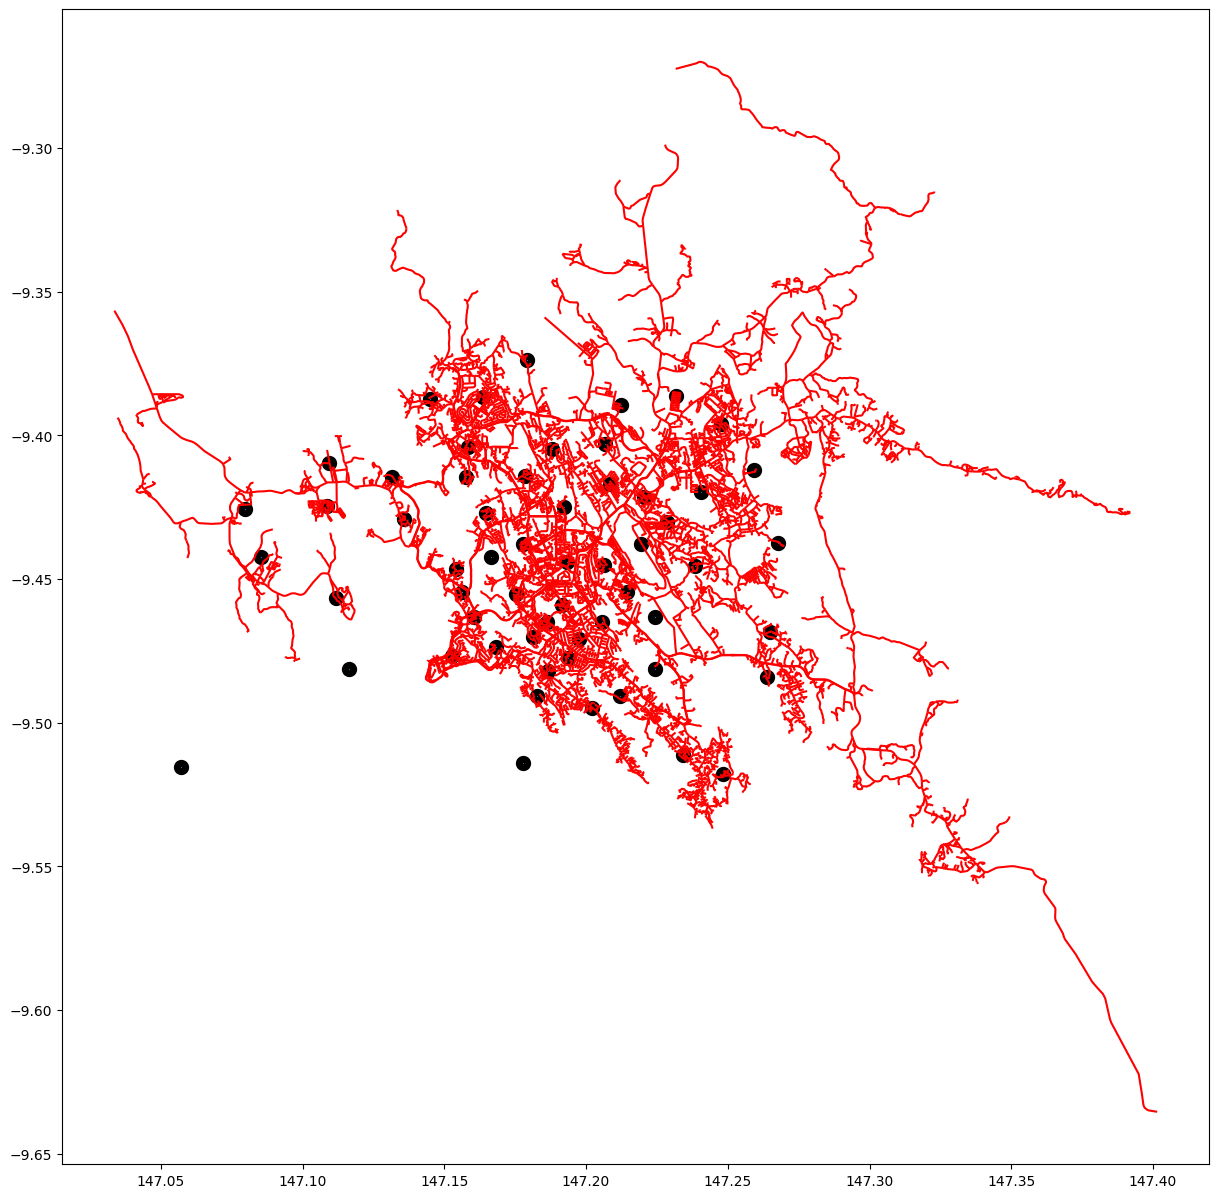

In [404]:
if var['network_preparation']['zone_clusterization']:
     clusters = var['network_preparation']['n_zone_clusters'] 

     a, b = spatial.zone_clusters(zones, n_clusters=clusters,geo_join_method=lambda x: x)
     if manual:
          ax=gpd.GeoDataFrame(a).plot(figsize=[25, 15], edgecolor='black', linewidth=5)
          rlinks.plot(ax=ax, color='red')
          
     zones['cluster'] = b
     zones_agg = zones.groupby(['cluster'])['density', 'population', 'jobs'].sum()
     zones_agg = gpd.GeoDataFrame(zones_agg, geometry= a['geometry'])
else:
     zones.index = zones.index.str.replace('_bc', '')
     zones_agg = zones


In [405]:
zones_poly['cluster'] = zones['cluster']
zones_poly = zones_poly.set_index('cluster').rename_axis('index')
zones_poly.index = 'zone_' + zones_poly.index.astype(str)

# split quenedi road links


In [406]:
from quetzal.engine.road_model import RoadModel, _reverse_geom

self = RoadModel(rlinks,rnodes,zones,ff_time_col='time')
self.split_quenedi_rlinks()
rlinks = self.road_links
to_delete = [col for col in self.road_links.columns if col.endswith('_r')]
rlinks.drop(columns=to_delete,inplace=True)
del self

In [407]:
rlinks['speed'] = rlinks['speed'].fillna(0).apply(float)

In [408]:
rlinks['time'] = rlinks['length'] / rlinks['speed'] *3.6

# create Model

In [409]:
sm = stepmodel.StepModel(epsg=4326)
sm.links = links
sm.nodes = nodes
sm.road_links = rlinks
sm.road_nodes = rnodes
sm.zones = zones_agg
sm.zones_before_clustering = zones
sm.zones_poly= zones_poly

In [410]:
# reccupération du crs réel du model
centroid = [*LineString(sm.nodes.centroid.values).centroid.coords][0]
crs = get_epsg(centroid[1],centroid[0])

In [411]:
sm = sm.change_epsg(crs,'meter')

Reprojecting model from epsg 4326 to epsg 32755:   0%|          | 0/13 [00:00<?, ?it/s]

Reprojecting model from epsg 4326 to epsg 32755: 100%|██████████| 13/13 [00:00<00:00, 16.81it/s]


# clustering

In [412]:
sm.disaggregated_nodes = sm.nodes.copy()

# Clustering by stop_code
if var["network_preparation"]["stop_code_clustering"]:
    from quetzal.engine.connectivity import node_clustering

    sm.links, sm.nodes, _, _ = node_clustering(sm.links, sm.nodes, group_id='stop_code')


# Distance Clustering by Mode
if var["network_preparation"]["dist_node_cluster"] > 0:
    links_concat = []
    nodes_concat = []
    i = 0
    for m in set(sm.links['route_type']):
        mode = sm.copy()
        mode.links = mode.links[mode.links['route_type'] == m].copy()
        mode.nodes = mode.nodes.loc[set(mode.links[['a', 'b']].values.flatten())].copy()

        mode.preparation_clusterize_nodes(distance_threshold = var["network_preparation"]["dist_node_cluster"])

        mode.nodes.index = (mode.nodes.index.astype('int') + i).astype(str)
        mode.links['a'] = (mode.links['a'].astype('int') + i).astype(str)
        mode.links['b'] = (mode.links['b'].astype('int') + i).astype(str)
        i += len(mode.nodes)

        links_concat.append(mode.links)
        nodes_concat.append(mode.nodes)

    sm.links = pd.concat(links_concat)
    sm.nodes = pd.concat(nodes_concat)

In [413]:

def flatten_lists(listoflists):

    return [link for list in listoflists for link in list]

In [414]:
def interpolate_link_times(self):
    if 'road_link_list' in self.links.columns:
        l = self.links[['trip_id','a', 'b', 'link_sequence', 'time', 'length','road_link_list']]
    else: 
        l = self.links[['trip_id','a', 'b', 'link_sequence', 'time', 'length']]

    l['next_node'] = l['a'] != l['b']
    l['cumsum'] = l['next_node'].cumsum()
    last_links = l.sort_values(by='link_sequence').drop_duplicates(subset=['trip_id'], keep='last')
    terminus = last_links[['trip_id', 'b', 'cumsum']]
    terminus['not_terminus'] = 0

    l = pd.merge(l, terminus, on=['trip_id', 'b', 'cumsum'], how='outer').fillna(1)
    l = l.sort_values(by=['trip_id', 'link_sequence'])

    l['next_node_not_terminus'] = (l['a'] != l['b']) & (l['not_terminus'])
    l['cumsum'] = l['next_node_not_terminus'].astype(int).cumsum()
    l['sequence'] =   [0]+ list(l['cumsum'].iloc[:-1]) 

    # keep only one row by a-b link
    if 'road_link_list' in self.links.columns:
        g = l.groupby(['trip_id', 'sequence'], as_index=False).agg({'time': 'sum', 'a': 'first', 'b': 'last', 'length': 'sum' ,'road_link_list': flatten_lists})
    else:
        g = l.groupby(['trip_id', 'sequence'], as_index=False).agg({'time': 'sum', 'a': 'first', 'b': 'last', 'length': 'sum'})
                                                            

    # clean sequences
    right = g.sort_values(['trip_id','sequence']).drop_duplicates(['trip_id'])[['trip_id', 'sequence']]
    g = pd.merge(g, right, on=['trip_id'], suffixes=['', '_min'])
    g['link_sequence'] = g['sequence'] - g['sequence_min'] + 1

    # merge link attributes on links
    right = self.links.drop_duplicates(subset='trip_id', keep='first')
    right.drop(['a', 'b', 'time', 'link_sequence', 'length','road_link_list'], axis=1, inplace=True, errors='ignore')

    links = pd.merge(g, right, on='trip_id')
    links = links.loc[links['a'] != links['b']] # drop lines with only one a -> b = a link
    
    self.links = links

In [415]:
interpolate_link_times(sm)

In [416]:
sm.links['geometry'] = [LineString(xy) for xy in zip(sm.nodes.loc[sm.links['a'].values]['geometry'].values, sm.nodes.loc[sm.links['b'].values]['geometry'].values)] 

In [417]:
sm._add_type_prefixes({'links':'links_', 'nodes':'nodes_', 'zones':'zone_', })


can not add prefixes on table:  footpaths


# walkmodel

In [418]:
sm.road_links['walk_time'] = sm.road_links['length'] / var['footpaths']['wor_speed'] * 3.6

In [419]:
sm.preparation_footpaths(max_length=var['footpaths']['max_length'],
                         speed=var['footpaths']['speed'])


In [420]:
# Zone to transit
sm.preparation_ntlegs(
    short_leg_speed = var['zone_to_transit']['speed'],
    long_leg_speed = var['zone_to_transit']['speed'], 
    threshold = var['zone_to_transit']['threshold'],
    zone_to_transit = True,
    zone_to_road = True,
    road_to_transit = True,
    n_ntlegs = var['zone_to_transit']['nbr'],
    max_ntleg_length = var['zone_to_transit']['max_length'],
)
sm._add_type_prefixes({'zone_to_transit':'ztt_'})

In [421]:
sm.integrity_test_all(errors='ignore', verbose=True)

passed: integrity_test_circular_lines
passed: integrity_test_collision


10320it [00:00, 101239.42it/s]

passed: integrity_test_dead_ends
passed: integrity_test_duplicate_volumes


passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency
failed: integrity_test_road_duplicated_ab_links


10320it [00:00, 30829.44it/s]


failed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences
passed: integrity_test_str_collision


In [422]:
sm.road_links.drop_duplicates(subset= ['a','b'], inplace=True)

In [423]:
sm.links['route_id']= sm.links['agency_id']
#sm.links['agency_id'] = sm.links['route_type']
sm.links.loc[sm.links['route_type'] == 'PMV', ['agency_id']] = sm.links['route_type']
sm.links.loc[sm.links['route_type'] == 'NCD', ['agency_id']] = sm.links['route_type']
sm.links.loc[sm.links['route_type'] == 'PMV', ['route_type']]= 'bus'
sm.links.loc[sm.links['route_type'] == 'NCD', ['route_type']]= 'bus'

In [424]:
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

sm.to_zippedpickles(model_folder +'network')  

broken_sequences: 100%|██████████| 25/25 [00:00<00:00, 47.02it/s]       


In [425]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined